# Ch 6 Principal Component Analysis (PCA)

<a target="_blank" href="https://colab.research.google.com/github/DrJaewookLee/math4ai-notes/blob/main/Notebooks/ch06_Principal_Component_Analysis.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

*Example with Iris dataset*

This notebook demonstrates **two fundamental approaches** to Principal Component Analysis:

**Approach 1: Eigendecomposition-based PCA** (Variance Maximization)

**Approach 2: SVD-based PCA** (Direct Matrix Decomposition)  

## 6.2 Principal Component Analysis

In [33]:
# Import the iris data set
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression

# Load iris dataset
iris = load_iris()
df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target

# Map target numbers to species names
species_names = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
df_iris['species_name'] = df_iris['species'].map(species_names)

print("Iris dataset shape:", df_iris.shape)
print("\nFeature names:")
print(iris.feature_names)
print("\nTarget names:")
print(iris.target_names)
print("\nFirst few rows:")
df_iris.head()

Iris dataset shape: (150, 6)

Feature names:
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Target names:
['setosa' 'versicolor' 'virginica']

First few rows:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [34]:
# Split the data into 70% training and 30% test subsets
# Use features (4 dimensions) and target
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                     stratify=y, # Stratified sampling for balanced classes split
                     random_state=0)  # Split into 70:30 ratio

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]} dimensions")
print(f"Classes: {len(np.unique(y))}")

Training set: 105 samples
Test set: 45 samples
Features: 4 dimensions
Classes: 3


In [35]:
# Standardize the data
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)  # Transform test set using training set parameters

---

## Method 1: Eigendecomposition-based PCA (Variance Maximization)

This section implements PCA using the **classical eigendecomposition approach**:

1. **Step 1**: Compute the covariance matrix `C = X^T X / (n-1)` for Standardized X
2. **Step 2**: Find eigenvalues and eigenvectors of the covariance matrix
3. **Step 3**: Sort eigenvectors by eigenvalue magnitude (descending)
4. **Step 4**: Select top-k eigenvectors as principal components
5. **Step 5**: Project data onto principal component space

**Key Insight**: Eigenvalues represent the variance captured by each principal component.

In [36]:
# Calculate the covariance matrix and eigenvalues
cov_mat = np.cov(X_train_std.T)  # Calculate covariance matrix
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)  # np.linalg.eigh is also recommended

print('Eigenvalues \n%s' % eigen_vals)
print(f"\nNumber of features (dimensions): {len(eigen_vals)}")
print("Eigenvalues in descending order:")
for i, val in enumerate(sorted(eigen_vals, reverse=True)):
    print(f"  PC{i+1}: {val:.6f}")

Eigenvalues 
[2.9260512  0.95479387 0.13823146 0.01938501]

Number of features (dimensions): 4
Eigenvalues in descending order:
  PC1: 2.926051
  PC2: 0.954794
  PC3: 0.138231
  PC4: 0.019385


Projection Matrix W:
 [[ 0.523215   -0.38039416]
 [-0.25169956 -0.92371023]
 [ 0.58317039 -0.01602484]
 [ 0.56815992 -0.04246043]]


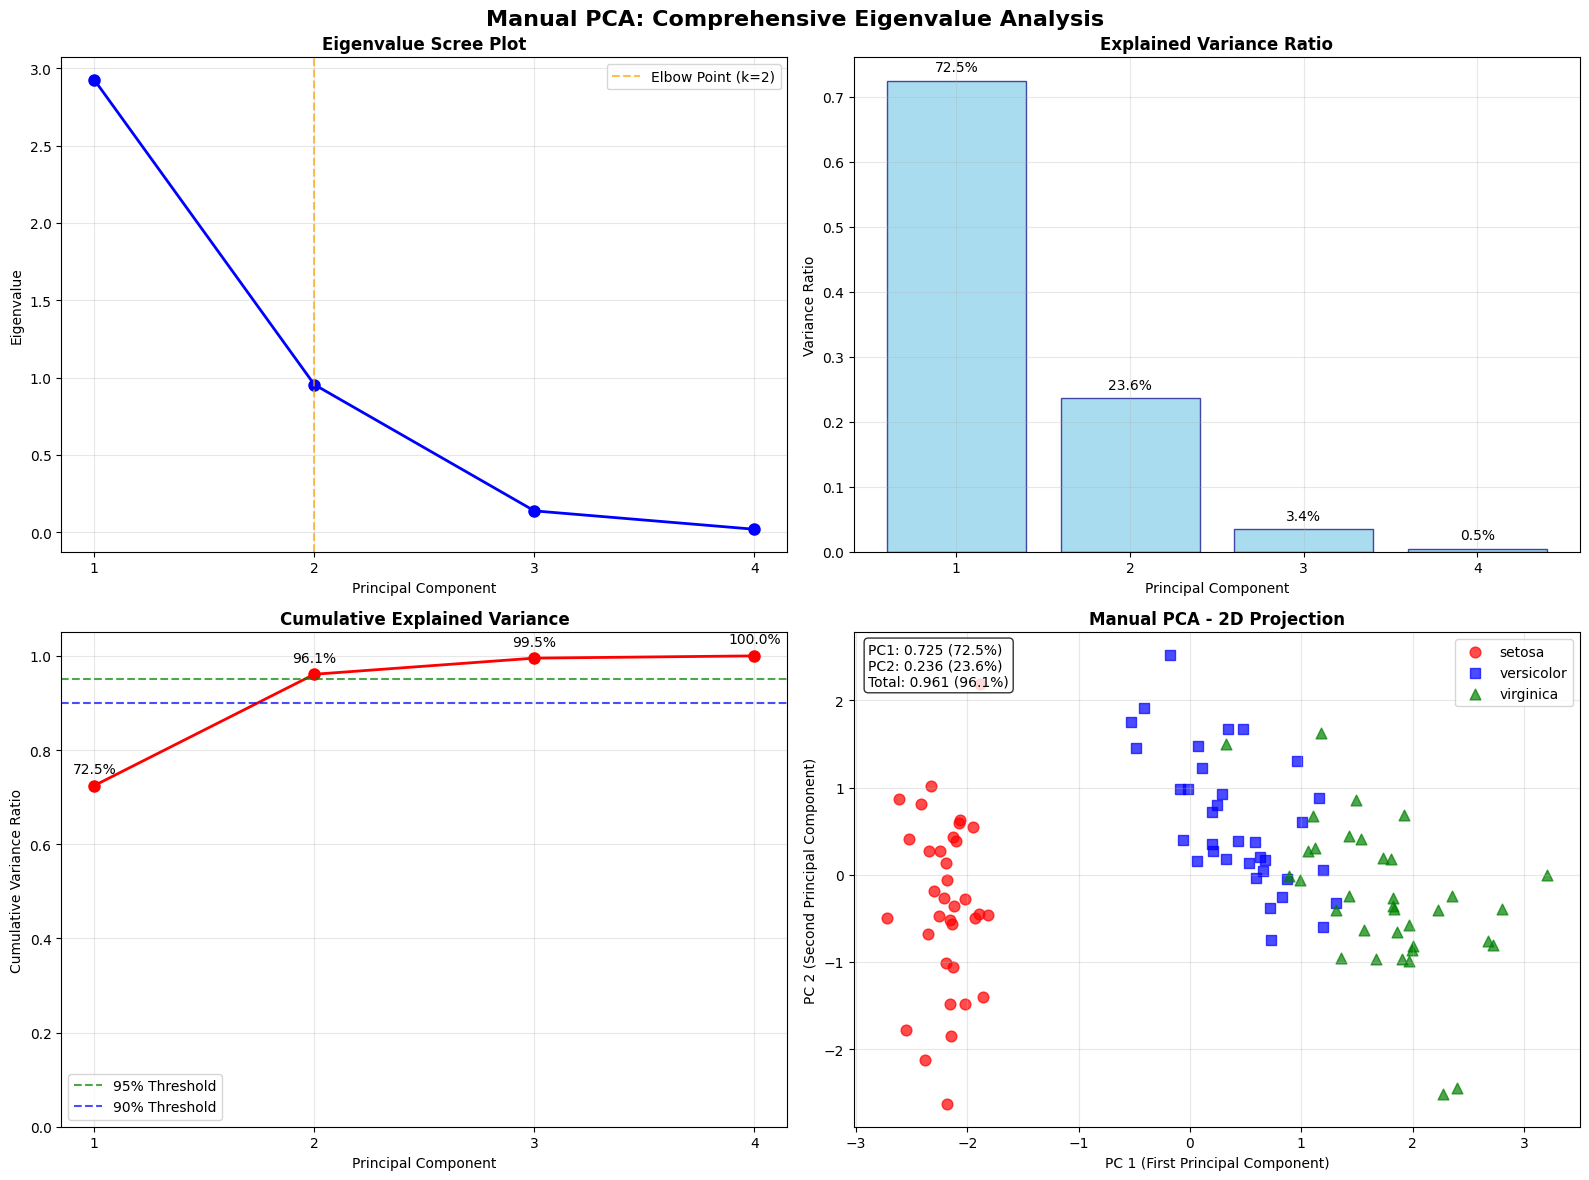

EIGENVALUE ANALYSIS SUMMARY

EIGENVALUE BREAKDOWN:
  PC1: Eigenvalue = 2.9261, Variance = 0.7245 (72.45%)
  PC2: Eigenvalue = 0.9548, Variance = 0.2364 (23.64%)
  PC3: Eigenvalue = 0.1382, Variance = 0.0342 (3.42%)
  PC4: Eigenvalue = 0.0194, Variance = 0.0048 (0.48%)

COMPONENT SELECTION CRITERIA:
  First 2 PCs explain: 96.10% of total variance
  Elbow Method suggests: 2 components (PC2)

CONCLUSION:
  • First 2 PCs capture 96.1% of variance
  • Significant dimension reduction: 4D → 2D
  • Good separation of Iris species maintained


In [37]:
# Manual PCA: Make a list of (eigenvalue, eigenvector) tuples and create projection matrix
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Create projection matrix W using first 2 principal components
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Projection Matrix W:\n', w)

# Prepare data for comprehensive eigenvalue analysis
sorted_eigenvals = sorted(eigen_vals, reverse=True)
var_exp = [(i / sum(eigen_vals)) for i in sorted_eigenvals]
cum_var_exp = np.cumsum(var_exp)

# Create comprehensive 2x2 subplot visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Eigenvalue Scree Plot (Top Left)
axes[0, 0].plot(range(1, len(sorted_eigenvals)+1), sorted_eigenvals, 'bo-', linewidth=2, markersize=8)
axes[0, 0].axvline(x=2, color='orange', linestyle='--', alpha=0.7, label='Elbow Point (k=2)')
axes[0, 0].set_title('Eigenvalue Scree Plot', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Eigenvalue')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_xticks(range(1, len(sorted_eigenvals)+1))

# 2. Explained Variance Ratio (Top Right)  
bars = axes[0, 1].bar(range(1, len(var_exp)+1), var_exp, alpha=0.7, color='skyblue', edgecolor='navy')
axes[0, 1].set_title('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Principal Component')
axes[0, 1].set_ylabel('Variance Ratio')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(1, len(var_exp)+1))

# Add percentage labels on bars
for i, (bar, var) in enumerate(zip(bars, var_exp)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{var*100:.1f}%', ha='center', va='bottom', fontsize=10)

# 3. Cumulative Explained Variance (Bottom Left)
axes[1, 0].plot(range(1, len(cum_var_exp)+1), cum_var_exp, 'ro-', linewidth=2, markersize=8)
axes[1, 0].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95% Threshold')
axes[1, 0].axhline(y=0.90, color='blue', linestyle='--', alpha=0.7, label='90% Threshold')
axes[1, 0].set_title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Principal Component')
axes[1, 0].set_ylabel('Cumulative Variance Ratio')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_xticks(range(1, len(cum_var_exp)+1))
axes[1, 0].set_ylim(0, 1.05)

# Add percentage labels
for i, cum_var in enumerate(cum_var_exp):
    axes[1, 0].text(i+1, cum_var + 0.02, f'{cum_var*100:.1f}%', 
                   ha='center', va='bottom', fontsize=10)

# 4. PCA Projection Scatter Plot (Bottom Right)
X_train_pca_manual = X_train_std.dot(w)
colors = ['red', 'blue', 'green'] 
markers = ['o', 's', '^']
species_names = ['setosa', 'versicolor', 'virginica']

for l, c, m, name in zip(np.unique(y_train), colors, markers, species_names):
    axes[1, 1].scatter(X_train_pca_manual[y_train == l, 0],
                      X_train_pca_manual[y_train == l, 1],
                      c=c, label=name, marker=m, alpha=0.7, s=60)

axes[1, 1].set_xlabel('PC 1 (First Principal Component)')
axes[1, 1].set_ylabel('PC 2 (Second Principal Component)')
axes[1, 1].set_title('Manual PCA - 2D Projection', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='upper right')
axes[1, 1].grid(True, alpha=0.3)

# Add variance info as text
var_text = f"PC1: {var_exp[0]:.3f} ({var_exp[0]*100:.1f}%)\nPC2: {var_exp[1]:.3f} ({var_exp[1]*100:.1f}%)\nTotal: {sum(var_exp[:2]):.3f} ({sum(var_exp[:2])*100:.1f}%)"
axes[1, 1].text(0.02, 0.98, var_text, transform=axes[1, 1].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Manual PCA: Comprehensive Eigenvalue Analysis', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("="*70)
print("EIGENVALUE ANALYSIS SUMMARY")
print("="*70)

print(f"\nEIGENVALUE BREAKDOWN:")
for i, (eigenval, var_ratio) in enumerate(zip(sorted_eigenvals, var_exp)):
    print(f"  PC{i+1}: Eigenvalue = {eigenval:.4f}, Variance = {var_ratio:.4f} ({var_ratio*100:.2f}%)")

print(f"\nCOMPONENT SELECTION CRITERIA:")
print(f"  First 2 PCs explain: {cum_var_exp[1]*100:.2f}% of total variance")

# Find elbow point using second derivative
if len(sorted_eigenvals) > 2:
    # Simple elbow detection using rate of change
    diff1 = np.diff(sorted_eigenvals)
    diff2 = np.diff(diff1)
    elbow_idx = np.argmax(diff2) + 2  # +2 due to double differencing
    print(f"  Elbow Method suggests: {elbow_idx} components (PC{elbow_idx})")

print(f"\nCONCLUSION:")
print(f"  • First 2 PCs capture {cum_var_exp[1]*100:.1f}% of variance")
print(f"  • Significant dimension reduction: 4D → 2D")
print(f"  • Good separation of Iris species maintained")
print("="*70)

---

## Method 2: SVD-based PCA (Direct Matrix Decomposition)

This section implements PCA using **Singular Value Decomposition (SVD)**:

1. **Step 1**: Apply SVD directly to the standardized data matrix: `X = UΣV^T`
2. **Step 2**: Extract principal components from `V^T` (right singular vectors)
3. **Step 3**: Calculate explained variance from singular values `Σ`
4. **Step 4**: Project data using `X @ V^T[:k]`

**Key Advantages**: 
- Better numerical stability (no covariance matrix computation)
- More efficient for high-dimensional data  
- Directly provides orthonormal principal components

In [38]:
# SVD-based PCA implementation
def pca_via_svd(X, n_components=2):
    """
    Perform PCA using Singular Value Decomposition (SVD)
    
    Args:
        X: Standardized data matrix (n_samples x n_features)
        n_components: Number of principal components to keep
        
    Returns:
        X_pca: Transformed data (n_samples x n_components)  
        components: Principal component vectors (n_components x n_features)
        explained_var_ratio: Explained variance ratio for each component
        singular_values: Singular values from SVD
    """
    # Perform SVD: X = U * Sigma * V^T
    U, sigma, V_T = np.linalg.svd(X, full_matrices=False)
    
    # Principal components are rows of V^T (or columns of V)
    components = V_T[:n_components]  # Shape: (n_components, n_features)
    
    # Transform data to PC space: X_pca = X @ V.T = X @ components.T  
    X_pca = X @ components.T  # Shape: (n_samples, n_components)
    
    # Calculate explained variance ratio
    # Total variance = sum of squared singular values / (n_samples - 1)
    total_var = np.sum(sigma**2) / (X.shape[0] - 1)
    explained_var = (sigma[:n_components]**2) / (X.shape[0] - 1)
    explained_var_ratio = explained_var / total_var
    
    return X_pca, components, explained_var_ratio, sigma

# Apply SVD-based PCA to iris data
X_train_pca_svd, components_svd, var_ratio_svd, sigma_svd = pca_via_svd(X_train_std, n_components=2)

print("SVD-based PCA Results:")
print(f"Singular values: {sigma_svd}")
print(f"Explained variance ratio: {var_ratio_svd}")
print(f"Principal components shape: {components_svd.shape}")
print(f"Transformed data shape: {X_train_pca_svd.shape}")

print(f"\nSVD-based PCA - Explained variance ratio:")
for i, var in enumerate(var_ratio_svd):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

SVD-based PCA Results:
Singular values: [17.44446403  9.96486639  3.79157903  1.41987365]
Explained variance ratio: [0.72454601 0.23642515]
Principal components shape: (2, 4)
Transformed data shape: (105, 2)

SVD-based PCA - Explained variance ratio:
  PC1: 0.7245 (72.45%)
  PC2: 0.2364 (23.64%)


### Dimension Reduction for downstream task with Scikit-learn PCA
*example with type classification*

In [39]:
# Apply 2-component PCA for visualization and classification
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(f"2D PCA projection shapes:")
print(f"  Training: {X_train_pca.shape}")
print(f"  Test: {X_test_pca.shape}")
print(f"Variance explained by first 2 components: {np.sum(pca.explained_variance_ratio_):.4f} ({np.sum(pca.explained_variance_ratio_)*100:.2f}%)")

2D PCA projection shapes:
  Training: (105, 2)
  Test: (45, 2)
Variance explained by first 2 components: 0.9610 (96.10%)


In [ ]:
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # Set plot range using x range
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.6,
                    color=cmap(idx),
                    marker=markers[idx],
                    label=cl)

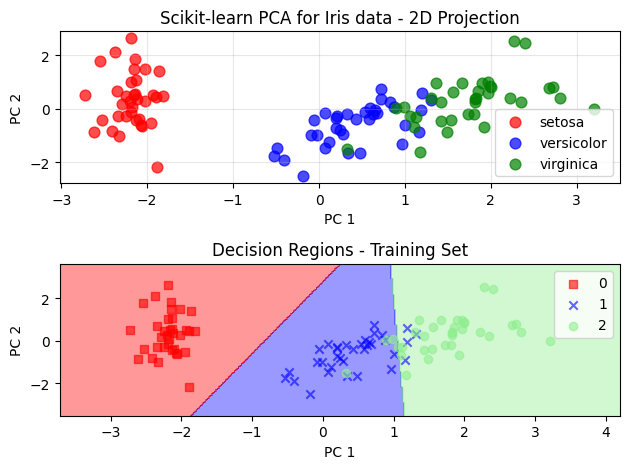

Training accuracy: 0.9238 (92.38%)


In [41]:
# Visualize 2D PCA projection and train logistic regression
plt.figure()

# PCA visualization
plt.subplot(2, 1, 1)
colors = ['red', 'blue', 'green']
species_names = ['setosa', 'versicolor', 'virginica']

for i, (color, name) in enumerate(zip(colors, species_names)):
    plt.scatter(X_train_pca[y_train == i, 0], X_train_pca[y_train == i, 1], 
                color=color, label=name, alpha=0.7, s=60)

plt.xlabel('PC 1')
plt.ylabel('PC 2')  
plt.title('Scikit-learn PCA for Iris data - 2D Projection')
plt.legend()
plt.grid(True, alpha=0.3)

# Train logistic regression classifier
lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)

# Plot decision regions
plt.subplot(2, 1, 2)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Decision Regions - Training Set')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print training accuracy
train_accuracy = lr.score(X_train_pca, y_train)
print(f"Training accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

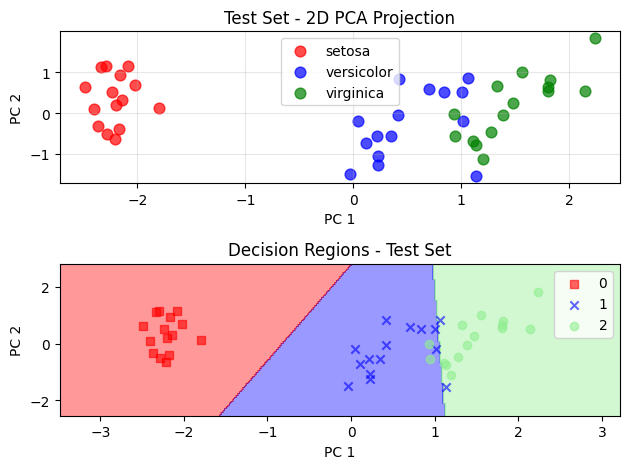

PCA ANALYSIS SUMMARY - IRIS DATASET
1. DIMENSIONALITY REDUCTION:
  Original features: 4D → Reduced features: 2D
  Dimension reduction: 50.0%
  Variance preserved: 0.9610 (96.10%)
2. MODEL PERFORMANCE:
  Training accuracy: 0.9238 (92.38%)
  Test accuracy: 0.9111 (91.11%)
  Generalization gap: 1.27%
3. PCA COMPONENTS:
  PC1: 0.7245 (72.45%)
  PC2: 0.2364 (23.64%)
4. CONCLUSION:
  PCA successfully reduced dimensionality from 4D to 2D
  while preserving 96.1% of variance and maintaining
  excellent classification performance (91.1% accuracy).


In [42]:
# Test set evaluation and performance summary
# Test set visualization
plt.figure()
plt.subplot(2, 1, 1)
colors = ['red', 'blue', 'green']
species_names = ['setosa', 'versicolor', 'virginica']

for i, (color, name) in enumerate(zip(colors, species_names)):
    plt.scatter(X_test_pca[y_test == i, 0], X_test_pca[y_test == i, 1], 
                color=color, label=name, alpha=0.7, s=60)

plt.xlabel('PC 1')
plt.ylabel('PC 2')  
plt.title('Test Set - 2D PCA Projection')
plt.legend()
plt.grid(True, alpha=0.3)

# Test set decision regions
plt.subplot(2, 1, 2)
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Decision Regions - Test Set')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print comprehensive performance summary
test_accuracy = lr.score(X_test_pca, y_test)

print("="*50)
print("PCA ANALYSIS SUMMARY - IRIS DATASET")
print("="*50)

print(f"1. DIMENSIONALITY REDUCTION:")
print(f"  Original features: {X_train.shape[1]}D → Reduced features: {X_train_pca.shape[1]}D")
print(f"  Dimension reduction: {(1 - X_train_pca.shape[1]/X_train.shape[1])*100:.1f}%")
cum_var = np.sum(pca.explained_variance_ratio_)
print(f"  Variance preserved: {cum_var:.4f} ({cum_var*100:.2f}%)")

print(f"2. MODEL PERFORMANCE:")
print(f"  Training accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Generalization gap: {(train_accuracy - test_accuracy)*100:.2f}%")

print(f"3. PCA COMPONENTS:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

print(f"4. CONCLUSION:")
print(f"  PCA successfully reduced dimensionality from 4D to 2D")
print(f"  while preserving {cum_var*100:.1f}% of variance and maintaining")
print(f"  excellent classification performance ({test_accuracy*100:.1f}% accuracy).")
print("="*50)